<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_9_SkimLit/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.



## Confirm access to a GPU

In [1]:
!nvidia-smi

Fri Aug 20 08:54:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we´ll be replicating the paper above (PubMed 200k RCT), let´s download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign 
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
#Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we´ve gpt some text data, it´s time to become one with it.

And one of the best ways to become on with the data is to...

> Visualize, visualize, visualize

So with that in mind, let´s write a function to read in all of the lines on a target text file.

In [6]:
# Create function to read lines of a document
def get_lines(filename):
  """
  Read filename (a text filename) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let´s read in the training lines
train_lines = get_lines(data_dir+"train.txt") #read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

# Let´s think about how we want out data to look... 

How I think our data would be best represented...

```
[{'line_number': 0, 
  'target': 'BACKGROUND', 
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines': 11}
  ...]
```

In [9]:
def  preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of bastract line data.

  Takes in filename, reads it contents and sorts through each line, extracting
  thing like the target label, the text of the sentence, how many sentences are in the current
  abstract and what sentence number the target line is
  """

  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" #create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the lines is an ID line
    elif line.isspace(): #check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() #split abstract lines in separate lines

      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dict for each line
        target_text_split = abstract_line.split("\t") #split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number #what number line doeas the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) -1 #how many total lines are there in the target abstract (starts with 0 - therfore minus 1)
        abstract_samples.append(line_data) #add line data to abstract sample list
      
    else: #if the above conditions aren´t fulfilled, the line contain a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
#Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
#Check the first abstract of our training data
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn into a DataFram to further visualize

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

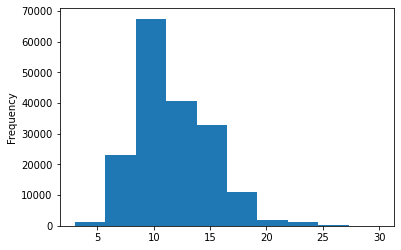

In [14]:
# Check len of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
#First 10 sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [17]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) #we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target columns") and encode them into intergers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_encoded

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we´re going to be trying out a bunch of different models and seeing which one works best.

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
#Evaluate the baseline model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [22]:
#Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

Download helper function script

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-20 08:55:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-20 08:55:13 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
#Calculate baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models

Before we start building deeper models, we´ve got to create vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

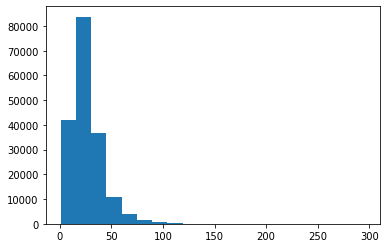

In [28]:
# What´s the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [29]:
# How long of a sentence length cover 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set 
max(sent_lens)

296

### Create text vectorizer layer

Layer which maps our text to numbers

In [31]:
# How many words are in our voca? (taken from tabe 2 in original paper)
max_tokens = 68000

In [32]:
#Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #number of words in vocab
                                    output_sequence_length=output_seq_len) #desired output length

In [33]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
scenarios of implementing such a strategy in the dutch screening or health care system are currently being discussed with various stakeholders .

Length of text: 22

Vectorized text: [[3229    4 3263  345    8  606    5    2 2496  387   16   97   77  355
    58 1325  571 3341    7 1139 7150    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), #vocab length
                               output_dim=128, #embedding dimension has a huge impact to the amount of model parameters
                               mask_zero=True, #use masking to handle variable sequence length - more efficient
                               name="token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization :\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 scenarios of implementing such a strategy in the dutch screening or health care system are currently being discussed with various stakeholders .

Sentence after vectorization :
 [[3229    4 3263  345    8  606    5    2 2496  387   16   97   77  355
    58 1325  571 3341    7 1139 7150    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding:
 [[[ 0.04167995  0.03134197 -0.01108661 ... -0.02768364 -0.01570012
    0.00777984]
  [ 0.01759312  0.01600785 -0.0193491  ...  0.03376235 -0.04480448
    0.03848255]
  [ 0.02254227  0.03804567 -0.00582469 ... -0.02860291  0.04661075
    0.02978161]
  ...
  [-0.04591805 -0.00091623  0.03032395 ... -0.040532   -0.0384893
   -0.00548769]
  [-0.04591805 -0.00091623  0.03032395 ... -0.040532   -0.0384893
   -0.00548769]
  [-0.04591805 -0.00091623  0.03032395 ... -0.040532   -0.0

## Creating datasets

We´re going to setup our data to run as fast as possible with the TensorFlow tf.data API

In [39]:
#Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [40]:
#Take the TensorSliceDataset´s and turn the into prefetched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [41]:
#Create 1D conv model to precess sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [42]:
#compile the model
model_1.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 8ms/step - loss: 0.9155 - accuracy: 0.6347 - val_loss: 0.6861 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6534 - accuracy: 0.7592 - val_loss: 0.6239 - val_accuracy: 0.7726
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6125 - accuracy: 0.7768 - val_loss: 0.5917 - val_accuracy: 0.7859


In [45]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5929 - accuracy: 0.7876


[0.5929479002952576, 0.7876340746879578]

In [46]:
# Make predictions (our model predicts prediction probabilities)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.67411250e-01, 1.81510061e-01, 7.46657327e-02, 2.49796405e-01,
         2.66165268e-02],
        [4.45767075e-01, 2.94736117e-01, 1.53169530e-02, 2.32763916e-01,
         1.14159519e-02],
        [1.19244054e-01, 4.71818307e-03, 1.42951310e-03, 8.74548793e-01,
         5.94178600e-05],
        ...,
        [3.68818223e-06, 5.00875991e-04, 4.48371982e-04, 2.11017687e-06,
         9.99044955e-01],
        [4.83167879e-02, 4.59475130e-01, 1.05099037e-01, 5.94637841e-02,
         3.27645332e-01],
        [1.82569370e-01, 6.76066637e-01, 4.56586592e-02, 4.59321141e-02,
         4.97730933e-02]], dtype=float32), (30212, 5))

In [47]:
#Convert pred probs to classes 
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.76340526942937,
 'f1': 0.7850544749298518,
 'precision': 0.7842702746069542,
 'recall': 0.7876340526942937}

## Model 2: Feature extraction with pretrained token embeddings

In [49]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False,
                                       name="universal_sentence_encoder")

In [50]:
#Test out embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
a total of @ consecutive people with epilepsy were enrolled from the epilepsy clinic of a tertiary care hospital in north india .
Sentence after embedding:
[-0.0356731   0.06976033  0.01791667 -0.07122005  0.00345451  0.06765463
  0.00969753  0.02238892  0.01144036 -0.06706045  0.0832843   0.06462184
 -0.03516258  0.05317726  0.04571813 -0.00656716 -0.08378866 -0.0028788
 -0.06514843 -0.05506721 -0.05628474 -0.00431261  0.06424575  0.02625145
 -0.0160864  -0.056775    0.01024947  0.05945393 -0.02139491  0.00157114]

Length of sentence embedding: 512


## Building an fitting an NLP feature extraction model using pretrained embeddings

In [51]:
#Build the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

In [52]:
#Compile the mpdel
model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [53]:
#Fit the model
history_model_2 = model_2.fit(train_dataset, epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset, 
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 12ms/step - loss: 0.9130 - accuracy: 0.6511 - val_loss: 0.7965 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7684 - accuracy: 0.7026 - val_loss: 0.7543 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7521 - accuracy: 0.7133 - val_loss: 0.7371 - val_accuracy: 0.7151


In [54]:
# Evaluate on the whole validation set
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7406 - accuracy: 0.7147


[0.7405902147293091, 0.7147160172462463]

In [55]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[3.9955875e-01, 3.8330820e-01, 2.6949840e-03, 2.0563364e-01,
        8.8044629e-03],
       [3.2505840e-01, 5.4507518e-01, 4.6847202e-03, 1.2241491e-01,
        2.7667517e-03],
       [2.2697653e-01, 1.3712128e-01, 2.0997364e-02, 5.7613933e-01,
        3.8765471e-02],
       ...,
       [1.5921070e-03, 4.7629634e-03, 5.6708504e-02, 8.3990203e-04,
        9.3609649e-01],
       [3.9957347e-03, 4.5414783e-02, 1.9665946e-01, 1.5340467e-03,
        7.5239593e-01],
       [1.5042873e-01, 2.8687552e-01, 5.0261599e-01, 6.7594973e-03,
        5.3320300e-02]], dtype=float32)

In [56]:
#convert prediction probabilities
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
#Calculate Results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.47160068846816,
 'f1': 0.7118438483369793,
 'precision': 0.7151991355431538,
 'recall': 0.7147160068846816}

## Model 3: Conv1D with character embeddings

Each character get´s turned into a feature vector

### Creating a character-level tokenizer

In [58]:
# Make funktion to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting nono-chracter-level sequence into character
split_chars(random_train_sentence)

'a   t o t a l   o f   @   c o n s e c u t i v e   p e o p l e   w i t h   e p i l e p s y   w e r e   e n r o l l e d   f r o m   t h e   e p i l e p s y   c l i n i c   o f   a   t e r t i a r y   c a r e   h o s p i t a l   i n   n o r t h   i n d i a   .'

In [59]:
#Split data into characters
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [60]:
# What´s the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

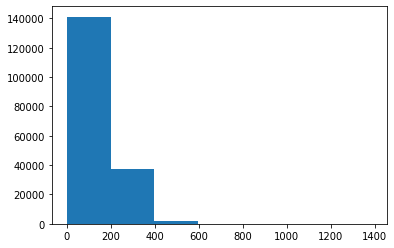

In [61]:
# Check the distribution of our sequences of character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [62]:
# Find what character length covers 96% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [63]:
# Get all keyboard character
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", 
                                    name="char_vectorizer")

In [65]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [66]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"Length of random_train_char: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
 p a t i e n t s   (   n   =   @ , @   )   w e r e   a g e d   @   t o   @   y e a r s   ,   p r e s e n t i n g   w i t h   h y p e r t e n s i o n   ,   d y s l i p i d e m i a   ,   o r   d i a b e t e s   m e l l i t u s   r e c r u i t e d   b y   p r i m a r y   c a r e   p h y s i c i a n s   a t   @   c l i n i c s   i n   j a p a n   b e t w e e n   m a r c h   @   a n d   j u n e   @   ,   a n d   w e r e   f o l l o w e d   u p   f o r   u p   t o   @   y e a r s   ,   w i t h   l a s t   f o l l o w - u p   i n   m a y   @   .
Length of random_train_char: 217
\Vectorized chars:
 [[14  5  3  4  2  6  3  9  6 20  2  8  2  5 18  2 10  3  7 19  2  5  8  9
  14  8  2  9  2  6  3  4  6 18 20  4  3 13 13 19 14  2  8  3  2  6  9  4
   7  6 10 19  9 12  4 14  4 10  2 15  4  5  7  8 10  4  5 22  2  3  2  9
  15  2 12 12  4  3 16  9  8  2 11  8 16  4  3  2 10 22 19 14  8  4 15  5
   8 19 11  5  8  2 14 13 19  9  4 11  4  5  6  9  5  3 11 12  4  6  4 11
   9  4  6 27  

### Creating a character level embedding

In [68]:
#Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,#get this outout dim from research paper
                              mask_zero=True,
                              name="char_embed")

In [69]:
#Test out character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 p a t i e n t s   (   n   =   @ , @   )   w e r e   a g e d   @   t o   @   y e a r s   ,   p r e s e n t i n g   w i t h   h y p e r t e n s i o n   ,   d y s l i p i d e m i a   ,   o r   d i a b e t e s   m e l l i t u s   r e c r u i t e d   b y   p r i m a r y   c a r e   p h y s i c i a n s   a t   @   c l i n i c s   i n   j a p a n   b e t w e e n   m a r c h   @   a n d   j u n e   @   ,   a n d   w e r e   f o l l o w e d   u p   f o r   u p   t o   @   y e a r s   ,   w i t h   l a s t   f o l l o w - u p   i n   m a y   @   .
Embedded chars (after vectorization):
 [[[ 0.02925613  0.00299927 -0.02093896 ...  0.0200086   0.00968815
    0.02927328]
  [-0.04385784  0.00129021  0.04963234 ...  0.02699945  0.02127869
    0.00503736]
  [ 0.03125485 -0.0401331   0.029514   ...  0.02619145  0.03981717
    0.00575843]
  ...
  [-0.04419884 -0.04042646  0.00167444 ...  0.04709018  0.03339798
    0.00955804]
  [-0.04419884 -0.04042646  0.00167444 ...  0.04709018  0.0333

## Building a Conv1D model to fit on character embeddings

In [70]:
#Build the model
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

In [71]:
#Compile the model
model_3.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [72]:
#create cgar level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [73]:
#Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=valid_char_dataset,
                            validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2836 - accuracy: 0.4804 - val_loss: 1.0666 - val_accuracy: 0.5805
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0160 - accuracy: 0.5941 - val_loss: 0.9566 - val_accuracy: 0.6190
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9294 - accuracy: 0.6351 - val_loss: 0.8768 - val_accuracy: 0.6609


In [74]:
#Make predictions with character model only
model_3_preds_probs = model_3.predict(valid_char_dataset)
model_3_preds_probs

array([[0.15977643, 0.18194386, 0.2886221 , 0.31028852, 0.05936904],
       [0.2054278 , 0.55068505, 0.02758986, 0.15081432, 0.065483  ],
       [0.12895888, 0.28177378, 0.30070677, 0.15096056, 0.13759999],
       ...,
       [0.01658702, 0.03665575, 0.07760967, 0.02459767, 0.84454983],
       [0.01371901, 0.04061836, 0.19280456, 0.01914542, 0.7337127 ],
       [0.514102  , 0.3029358 , 0.11435943, 0.05315598, 0.01544677]],
      dtype=float32)

In [75]:
#Convert prediction probs to class labels
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 2, ..., 4, 4, 0])>

In [76]:
#Calculate the results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)

model_3_results

{'accuracy': 65.33827618164968,
 'f1': 0.6426188687153028,
 'precision': 0.6444536290278997,
 'recall': 0.6533827618164968}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer

1. Create a token-level embedding model (similar to model 1)
2. Create a character-level model (similar to model 3 with modifications)
3. Combine 1 & 2 with a concatenate layer
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 in research paper
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [77]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [78]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #24 Because this is a multiple of 8 - better for speed
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [79]:
# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [80]:
# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [81]:
# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.inputs],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [82]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

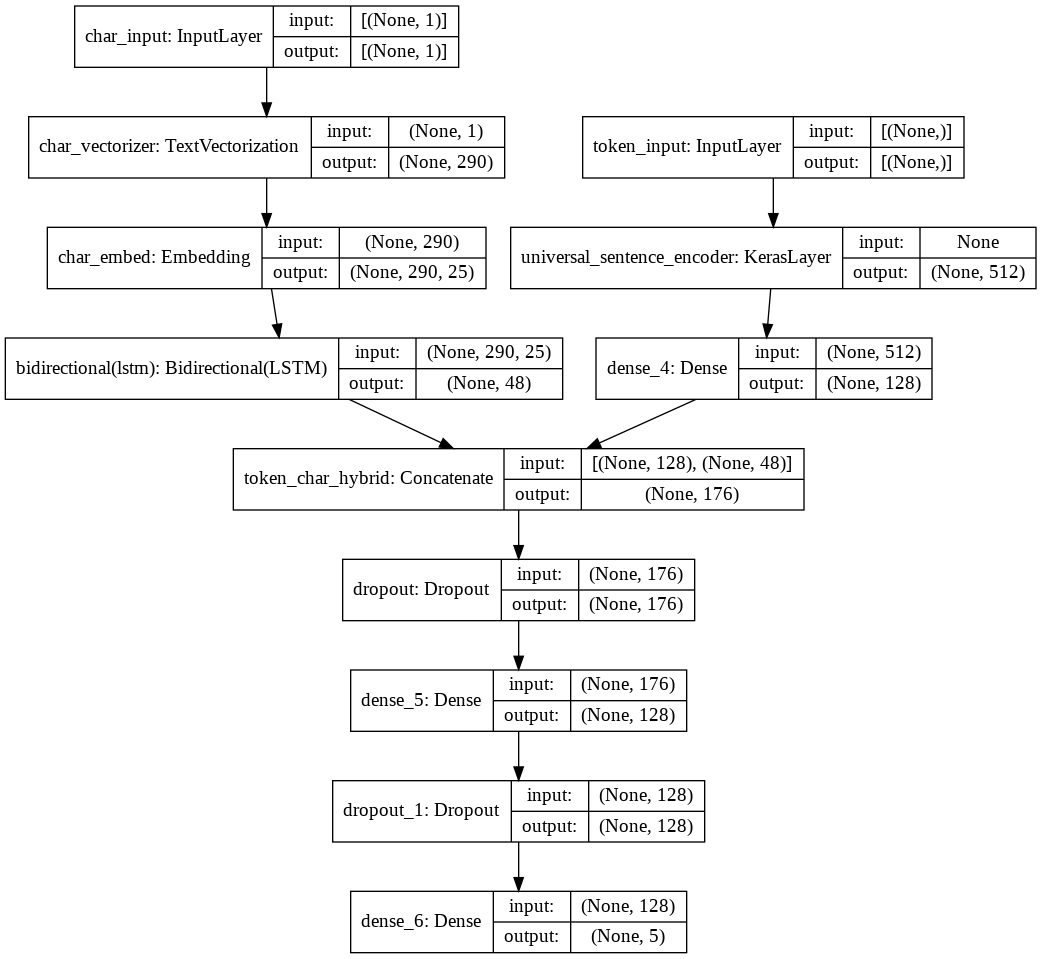

In [83]:
# Plot hybrid token and character model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [84]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [85]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combine data and labels

#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
#Repeat the steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels

#Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
#Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [88]:
#Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 47ms/step - loss: 0.9828 - accuracy: 0.6075 - val_loss: 0.7827 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.8022 - accuracy: 0.6891 - val_loss: 0.7202 - val_accuracy: 0.7244
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7709 - accuracy: 0.7064 - val_loss: 0.6947 - val_accuracy: 0.7367


In [89]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7018 - accuracy: 0.7324


[0.701834499835968, 0.7324241995811462]

In [90]:
#Make preductions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.8251548e-01, 2.9537088e-01, 5.8444459e-03, 2.0559110e-01,
        1.0678094e-02],
       [3.1649524e-01, 5.4581285e-01, 3.2022146e-03, 1.3179621e-01,
        2.6934948e-03],
       [2.6267815e-01, 9.1452636e-02, 4.6727341e-02, 5.6893438e-01,
        3.0207450e-02],
       ...,
       [1.0397678e-03, 1.0509318e-02, 8.4373020e-02, 4.7885251e-04,
        9.0359908e-01],
       [8.4843468e-03, 5.2972376e-02, 2.4060673e-01, 3.9370856e-03,
        6.9399947e-01],
       [2.1882324e-01, 2.7796677e-01, 4.1488343e-01, 2.3419194e-02,
        6.4907432e-02]], dtype=float32)

In [91]:
# Convert to predictions probabilities into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [92]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 73.24242023037203,
 'f1': 0.7298572286271806,
 'precision': 0.7339975411621177,
 'recall': 0.7324242023037204}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [93]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available. 

### Create positinal embeddings

In [94]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

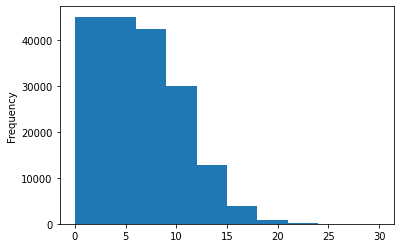

In [95]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [96]:
# Use TensorFlow to create one-hot-encoded tensors of our line_number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, <tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
 

In [97]:
# How many different number of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

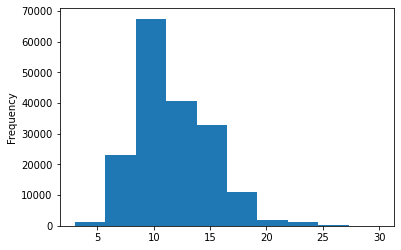

In [98]:
# Check the distribution of "total_lines" column
train_df.total_lines.plot.hist()

In [99]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [100]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a chracter-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2
6. Combine the outputs of 3, 4, 5
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a Model

In [101]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [102]:
# 2. Char Inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [103]:
# 3 Line numbers model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

In [104]:
# 4 Total lines model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

In [105]:
# 5 Combine token and char embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])

In [106]:
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [107]:
# 6 Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="cchar_token_positional_embedding")([line_number_model.output, total_line_model.output, z])

In [108]:
# 7 Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

In [109]:
# 8 Put together model with all kind of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer, name="model_5_tribrid_embedding_model")

In [110]:
#Get summary
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

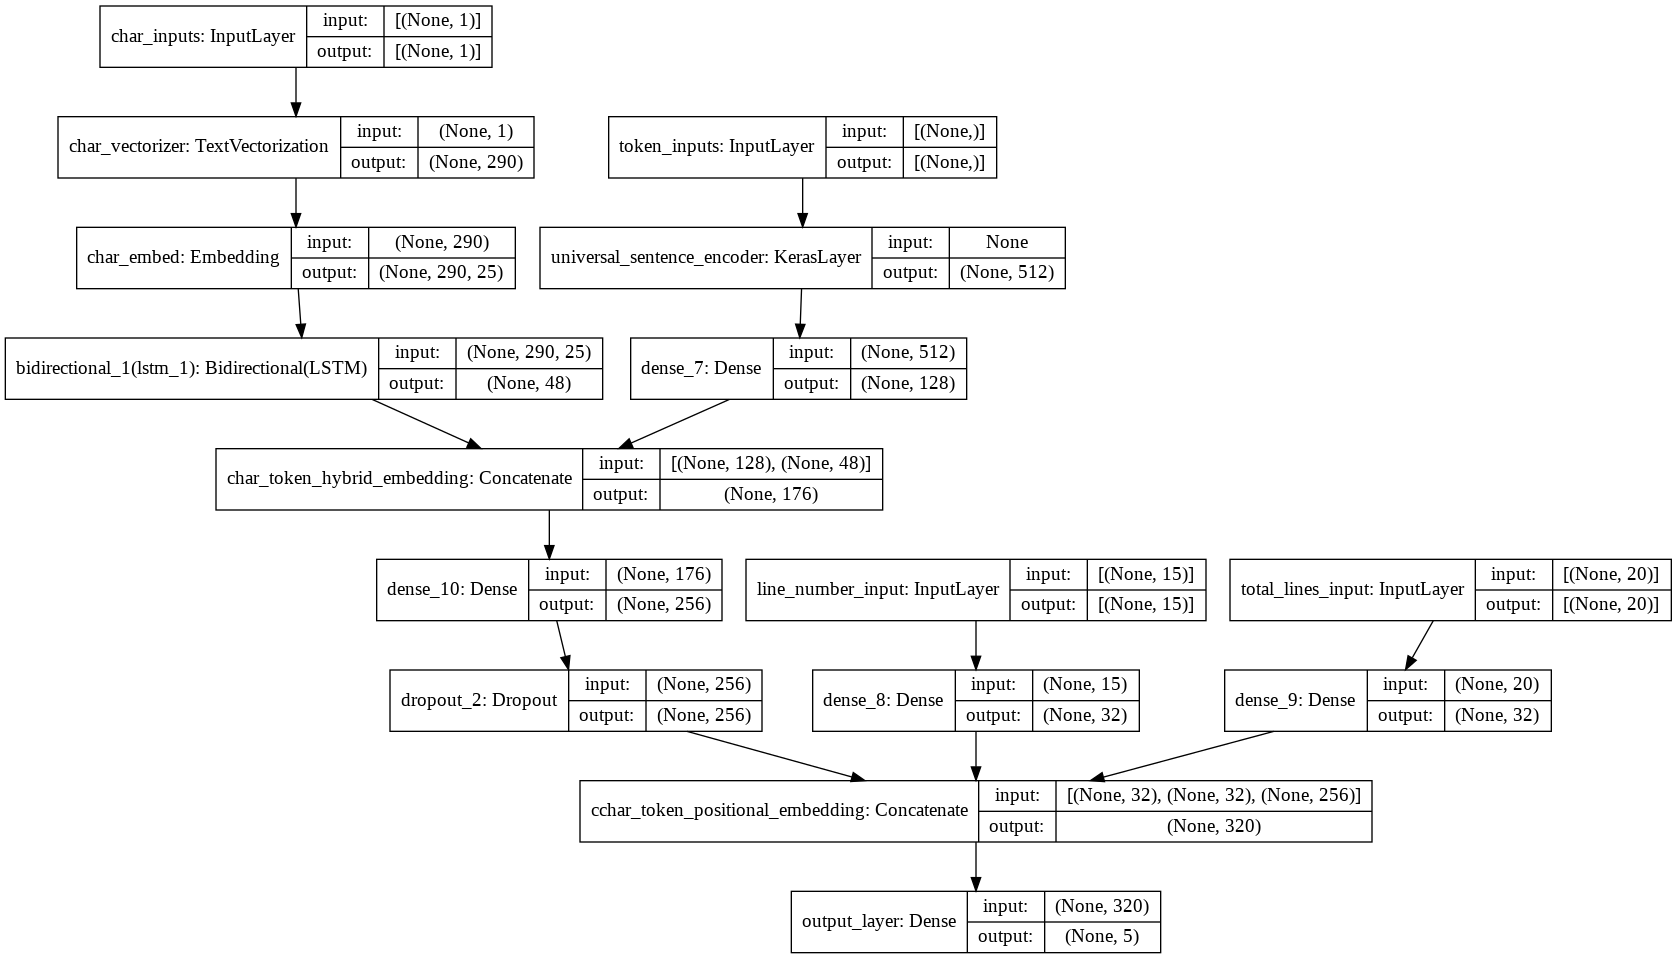

In [111]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [112]:
#Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer="Adam", metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [113]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                           train_total_lines_one_hot,
                                                           train_sentences,
                                                           train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Same for validation data

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                           val_total_lines_one_hot,
                                                           val_sentences,
                                                           val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [114]:
#Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

# Fitting, evaluating and make predictions

In [116]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 48ms/step - loss: 1.0985 - accuracy: 0.7212 - val_loss: 0.9826 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9647 - accuracy: 0.8154 - val_loss: 0.9490 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.9493 - accuracy: 0.8228 - val_loss: 0.9389 - val_accuracy: 0.8321


In [117]:
#Make predicions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

array([[0.5441208 , 0.0932525 , 0.01125771, 0.33369735, 0.01767162],
       [0.56178856, 0.0972449 , 0.03800661, 0.293347  , 0.00961288],
       [0.26916328, 0.09891409, 0.13670284, 0.43014497, 0.06507475],
       ...,
       [0.03360846, 0.10769735, 0.04882731, 0.03159868, 0.77826816],
       [0.03193644, 0.27652872, 0.08003299, 0.02608142, 0.5854204 ],
       [0.25631022, 0.5246673 , 0.10808089, 0.04877758, 0.06216399]],
      dtype=float32)

In [118]:
#Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [120]:
#Calculate results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.34767641996558,
 'f1': 0.832256801149542,
 'precision': 0.8327563924917049,
 'recall': 0.8334767641996558}

## Compare model results 

In [121]:
#Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_costum_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_costum_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_costum_token_embedding,78.763405,0.784270,0.787634,0.785054
model_2_pretrained_token_embedding,71.471601,0.715199,0.714716,0.711844
model_3_costum_char_embedding,65.338276,0.644454,0.653383,0.642619
model_4_hybrid_char_token_embedding,73.242420,0.733998,0.732424,0.729857
model_5_pos_char_token_embedding,83.347676,0.832756,0.833477,0.832257


In [122]:
#Reduce the accuracy to same scale
all_model_results["accuracy"] = all_model_results["accuracy"]/100

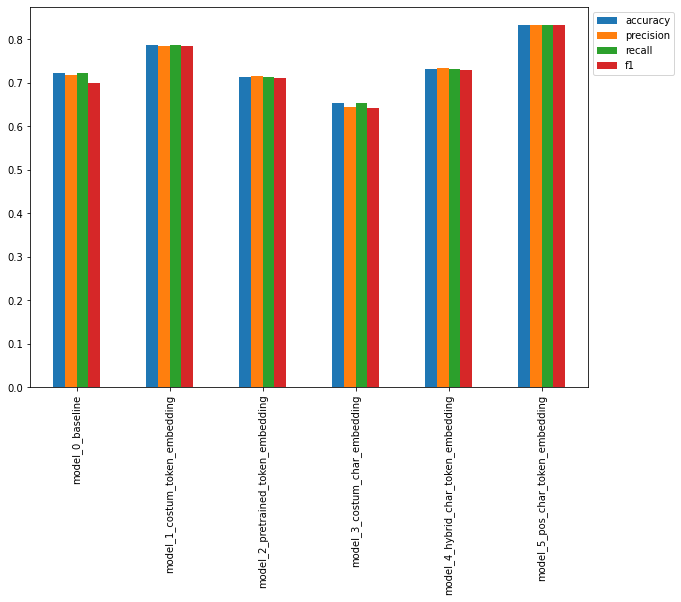

In [123]:
#Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

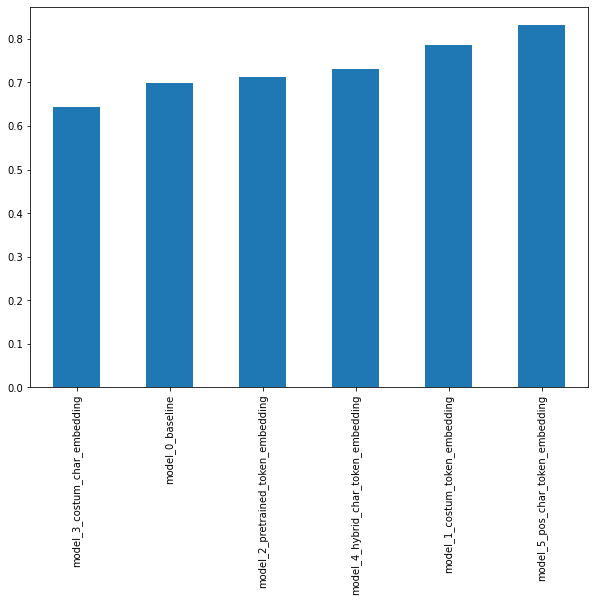

In [142]:
#Sort the model by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))